# Apply DeepGaze to Honda Data

In [2]:
# need to import torch before numpy
import torch
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp


import deepgaze_pytorch

# DEVICE = 'cuda'
# mps is for MacM1chip GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'

# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).float().to(DEVICE)

/Users/yilunxing/opt/anaconda3/envs/mydeepgaze_env/lib/python3.9/site-packages/torchvision-0.17.1-py3.9-macosx-10.9-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yilunxing/opt/anaconda3/envs/mydeepgaze_env/lib/python3.9/site-packages/torchvision-0.17.1-py3.9-macosx-10.9-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /Users/yilunxing/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/yilunxing/opt/anaconda3/envs/mydeepgaze_env/lib/python3.9/site-packages/torchvision-0.17.1-py3.9-macosx-10.9-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/yilunxing/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/yilunxing/opt/anaconda3/envs/mydeepgaze_env/lib/python3.9/site-packages/torchvision-0.17.1-py3.9-macosx-10.9-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Re

In [2]:
image = face()

/var/folders/zt/0sjlqcss6017rh66yvnwlwqm0000gn/T/ipykernel_27019/3380650164.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  image = face()


In [3]:
from PIL import Image
origin_image = Image.open('/Users/yilunxing/Documents/GitHub/DeepGaze/25_201703061606_31745_32026/25_201703061606_31745_32026_3601.png')
image = origin_image.resize((2880,600))
image = np.array(image)

In [42]:
image.shape

(1200, 5760, 3)

(1200, 5760, 3)

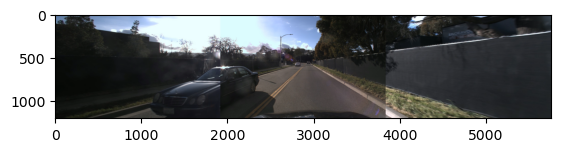

In [16]:
image = np.array(Image.open('/Users/yilunxing/Documents/GitHub/DeepGaze/25_201703061606_31745_32026/25_201703061606_31745_32026_3601.png'))
plt.imshow(image)
image.shape

In [4]:
# load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
centerbias_template = np.load('centerbias_mit1003.npy')

In [5]:
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).float().to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).float().to(DEVICE)
# image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
# centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model(image_tensor, centerbias_tensor)

/var/folders/zt/0sjlqcss6017rh66yvnwlwqm0000gn/T/ipykernel_29454/3930193357.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).float().to(DEVICE)


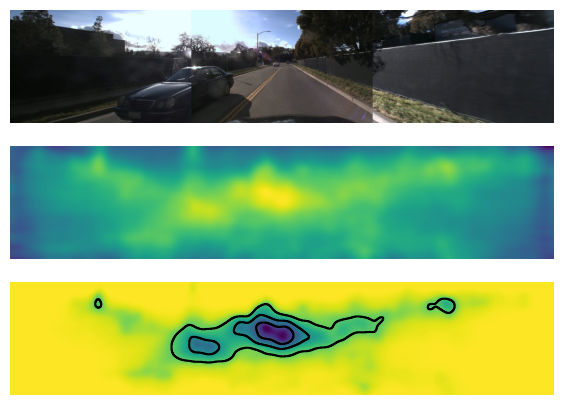

In [6]:
import matplotlib.pyplot as plt
from pysaliency.plotting import visualize_distribution

f, axs = plt.subplots(nrows=3, ncols=1, figsize=(24, 5))
# f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(image)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off()
visualize_distribution(log_density_prediction.detach().cpu().numpy()[0, 0], ax=axs[2])
axs[2].set_axis_off()

In [10]:
np.max(np.exp(log_density_prediction.detach().cpu().numpy()[0, 0]))

0.0021900981664657593